###Assignment Overview

The objective of this assignment is to build an end-to-end image classification pipeline using PyTorch.
The task involves loading and preparing an image dataset, designing a Convolutional Neural Network (CNN), training the model, and evaluating its performance on validation and test datasets.
This assignment demonstrates the complete deep learning workflow, including data preprocessing, model architecture design, training, and evaluation.



## Import Required Libraries

In this section, we import the libraries required for the assignment.
These libraries are used for dataset downloading, file handling, and building and training neural network models using PyTorch.


In [49]:
!pip -q install kagglehub

import os
import kagglehub


## Device Management

The computation device is selected based on availability.
If a GPU (CUDA) is available, it is used to accelerate training; otherwise, the model runs on the CPU.
This makes the notebook compatible with different execution environments.


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


Reproducibility

A fixed random seed is set to ensure reproducible results.
This helps maintain consistent training behavior across different runs.

In [51]:
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print("Random seed set to:", seed)


Random seed set to: 42


## Download the Dataset

Dataset Loading

In this step, the plant image dataset is downloaded from Kaggle using kagglehub.
The dataset contains images organized into training, validation, and test folders, which will be used for model development and evaluation.



In [52]:
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")
print("Dataset path:", path)


Using Colab cache for faster access to the 'plants-type-datasets' dataset.
Dataset path: /kaggle/input/plants-type-datasets


## Inspect Dataset Structure


Before building the datasets, the directory structure is inspected to ensure that the dataset has been downloaded correctly and that the expected folders are present.
This step helps verify the data organization and prevents path-related errors later.


In [53]:
print("Contents of dataset root:")
print(os.listdir(path))


Contents of dataset root:
['split_ttv_dataset_type_of_plants']


## Define Train/Validation/Test Paths

We explicitly define the directory paths for:
- `train_dir` (used for learning)
- `val_dir` (used for model selection / tuning)
- `test_dir` (used only for final evaluation)

Keeping these splits separate helps prevent data leakage and ensures a fair evaluation.


In [54]:
split_dir = os.path.join(path, "split_ttv_dataset_type_of_plants")
print("Train/Val/Test folders:")
print(os.listdir(split_dir))


Train/Val/Test folders:
['Test_Set_Folder', 'Validation_Set_Folder', 'Train_Set_Folder']


In [55]:
train_dir = os.path.join(split_dir, "Train_Set_Folder")
test_dir  = os.path.join(split_dir, "Test_Set_Folder")
val_dir   = os.path.join(split_dir, "Validation_Set_Folder")

print("Train:", train_dir)
print("Test :", test_dir)
print("Val  :", val_dir)


Train: /kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder
Test : /kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Test_Set_Folder
Val  : /kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Validation_Set_Folder


We define image preprocessing pipelines using torchvision.transforms.

- Training uses data augmentation (random horizontal flip) to improve generalization.
- Validation and test use deterministic preprocessing only.
All images are resized to 224x224 and normalized before being fed to the CNN.



In [56]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])



We use ImageFolder to build train/validation/test datasets from the class-per-folder directory structure.



In [57]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir, transform=eval_tfms)
test_ds  = ImageFolder(test_dir, transform=eval_tfms)

num_classes = len(train_ds.classes)
print("num_classes:", num_classes)
print("first 10 classes:", train_ds.classes[:10])



num_classes: 30
first 10 classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant']


## Create DataLoaders

We wrap each dataset with a `DataLoader` to:
- Load data in **mini-batches** (batch_size=32)
- Shuffle the training data to improve generalization
- Efficiently iterate through the dataset during training and evaluation

We also print the first batch shapes as a quick check that the pipeline is correct.


In [58]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

# Quick sanity check (first batch)
x, y = next(iter(train_loader))
print("Batch images shape:", x.shape)  # expected: [32, 3, 224, 224]
print("Batch labels shape:", y.shape)  # expected: [32]


Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


##  Visualize Training Samples (Sanity Check)

We visualize a small batch of training images and their labels to verify:
- Images are loaded correctly
- Labels match the correct class folder
- Preprocessing/transforms are applied as expected

This helps catch dataset or labeling issues before training the model.


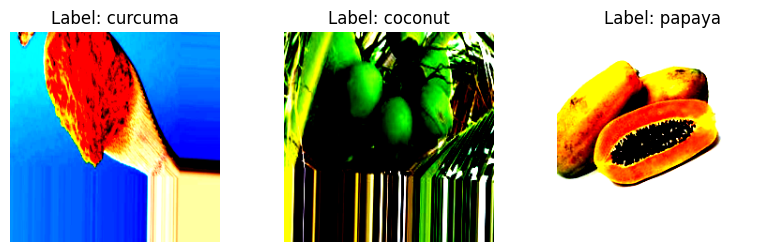

In [71]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(10,6))
for i in range(3):
    plt.subplot(2,3,i+1)
    img = images[i].permute(1,2,0)
    plt.imshow(img)
    plt.title(f"Label: {train_ds.classes[labels[i]]}")
    plt.axis("off")
plt.show()


##  Define the CNN Model

We define a simple CNN for multi-class image classification (30 classes):

- Convolution + ReLU blocks learn visual features (edges → textures → patterns) and add non-linearity.
- MaxPooling reduces spatial dimensions and helps with translation invariance.
- Global Average Pooling (AdaptiveAvgPool2d) reduces parameters by summarizing each feature map.
- The classifier uses Flatten → Linear(64→256) → ReLU → Dropout(0.3) → Linear(256→num_classes).
- The model outputs logits for each class (to be used with CrossEntropyLoss).



In [60]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x




In [61]:
model = SimpleCNN(num_classes).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=30, bias=True)
  )
)


## Model Training Setup

In this step, we define the components required to train the CNN model.

- **Loss Function:** CrossEntropyLoss is used because this is a multi-class classification problem where each image belongs to exactly one class.
- **Optimizer:** Adam optimizer is selected for its adaptive learning rate and good convergence behavior in deep learning models.

These components allow the model to compute prediction errors and update its parameters during training.



In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


### Training and Validation Loop

We implement a custom training loop that supports both training and validation phases.

- During training, the model updates its parameters using backpropagation.
- During validation, the model is evaluated without updating weights.
- Loss and accuracy are computed at each epoch to monitor learning progress.

This separation allows us to track model performance and detect potential overfitting.





In [63]:
def run_epoch(model, loader, training=True):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(training):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


In [64]:
best_val_acc = 0.0
best_epoch = 0
best_model_state = None

num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = run_epoch(model, train_loader, training=True)
    val_loss, val_acc     = run_epoch(model, val_loader, training=False)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict()

print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")



Epoch 1/5 | Train: loss=2.5025, acc=0.2411 | Val: loss=2.0307, acc=0.3739
Epoch 2/5 | Train: loss=1.9390, acc=0.3943 | Val: loss=1.7240, acc=0.4604
Epoch 3/5 | Train: loss=1.6792, acc=0.4687 | Val: loss=1.5264, acc=0.5254
Epoch 4/5 | Train: loss=1.5133, acc=0.5154 | Val: loss=1.3080, acc=0.5660
Epoch 5/5 | Train: loss=1.3876, acc=0.5509 | Val: loss=1.2134, acc=0.6168
Best validation accuracy: 0.6168 at epoch 5


### Training Results Analysis

From the training logs, we observe that:
- Training loss decreases steadily across epochs.
- Validation accuracy improves consistently over time.

This indicates that the model is learning meaningful features and generalizing reasonably well.



### Test Evaluation

After training and validation, the model is evaluated on the test set.
The test set is not used during training and provides an unbiased estimate of model performance.



In [65]:
test_loss, test_acc = run_epoch(model, test_loader, training=False)
print(f"Test loss={test_loss:.4f}, acc={test_acc:.4f}")


Test loss=1.2448, acc=0.6031


### Test Results and Interpretation

The final evaluation on the test dataset resulted in:
- **Test Accuracy:** 60.31%
- **Test Loss:** 1.2448

The test accuracy is lower than the validation accuracy, which is expected when evaluating on completely unseen data.
This suggests the model learned useful visual features, but generalization can still be improved.





## Conclusion

This assignment demonstrated an end-to-end CNN-based image classification workflow using PyTorch.
The model learned meaningful visual features from the plant image dataset and achieved reasonable
performance on validation and test data.

Overall, the project highlights the importance of proper data preprocessing, model training,
and evaluation when building image classification systems.
